# Generate uncertainties for $\rm K Er Se_2$ CEF Hamiltonian 

We loop through a series of $B_2^0$ values, re-fit the CEF Hamiltonian for each value, and then find a "Best-fit line" through parameter space as a function of $B_2^0$. We then truncate this line at the points where reduced $\chi^2$ increases by 1 over the global minimum, and use that to estimate uncertainty in the final calculated values.

Allen Scheie

December, 2019

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib.ticker import MultipleLocator
from matplotlib import gridspec
import sys

import PyCrystalField as cef
from pythonlib.MsliceData import mslice



## Import all the data

datadirectory = 'CES_CEF_data/'

cutlist =   ['CES_100K_9meV',            'CES_2K_9meV',
            'CES_50K_9meV',            'CES_2K_9meV_3T',
            'CES_2K_9meV_5T',            'CES_2K_9meV_0T',
            'CES_2K_9meV_1T',            'CES_2K_9meV_2T',
            'CES_2K_9meV_0Tb',    'CES_2K_30meV']

ProtonCharges = [7.97, 8*3, 8*3+5.61, 8+6.59, 5.07, 2, 4,4,1.13, 8*4+5.1]  
# The proton charge doesn't seem to correct the normalization problem.
# Rather, the sample seems to have decreased in intensity post-5T field...
# See the cell below where I derive the scale factor.
scalefactor = 1.66582869
Norm = [scalefactor, 1,1, scalefactor, scalefactor, scalefactor, 
        scalefactor, scalefactor, scalefactor, scalefactor,]

DATA = {}
for i,cn in enumerate(cutlist):
    DATA[cn] = mslice(datadirectory+cn)
    DATA[cn].normalize(1e3*Norm[i])
    
    
## Define data

alldata = [DATA[cn] for cn in ['CES_2K_9meV', 'CES_50K_9meV']]
datatemps = [1.8, 50]

In [2]:
ll, ul = 160, 260
def scalefitfun(x, a):
    return a*DATA['CES_2K_9meV_0T'].ci[ll:ul]
reference = DATA['CES_2K_9meV']
pscaleA, cscaleB = curve_fit(scalefitfun, reference.cx[ll:ul], reference.ci[ll:ul], p0=[2])
def scalefitfun(x, a):
    return a*DATA['CES_2K_9meV_0Tb'].ci[ll:ul]
reference = DATA['CES_2K_9meV']
pscaleB, cscaleB = curve_fit(scalefitfun, reference.cx[ll:ul], reference.ci[ll:ul], p0=[2])
print((pscaleA+pscaleB)/2)

scalevalue = np.mean([pscaleA, pscaleB])

[1.]


<IPython.core.display.Javascript object>


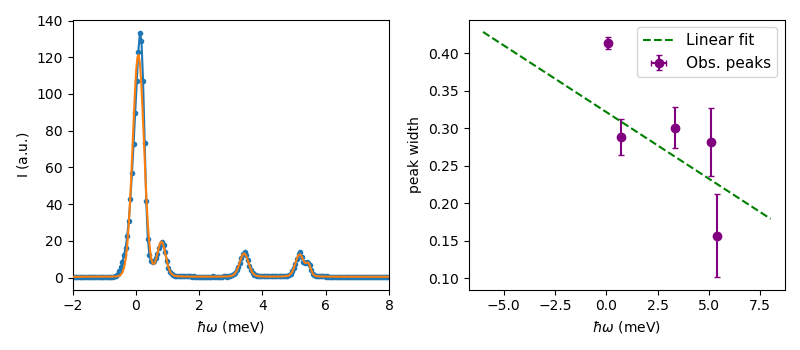

[0.07517211974600753, 0.7310563754703909, 3.3430389113350087, 5.0971456786049085, 5.377777212698675] [0.4132660062508849, 0.288638322840261, 0.3005368004446522, 0.2815966433551471, 0.1566254770893106] 0.050394384987051934
[-0.01778629  0.32154258]


In [3]:
## Pick out observed eigenvalues
from scipy.special import wofz

def gaus(x, a, x0, sig):
    return a/(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power((x - x0)/sig, 2.)/2.)

def voigt(x, a, x0, alpha, gamma):
    """ Return the Voigt line shape at x with Lorentzian component FWHM gamma
    and Gaussian component FWHM alpha."""
    sigma = (0.5*alpha) / np.sqrt(2 * np.log(2))
    return a*np.real(wofz(((x-x0) + 1j*(0.5*gamma))/sigma/np.sqrt(2))) / sigma\
                                                        /np.sqrt(2*np.pi)

dx, dy, de = alldata[0].cx, alldata[0].ci, alldata[0].ce

def gausfitfun(x, a0,x0,w0, a1,x1,w1, a2,x2,w2, a3,x3,w3, a4,x4,w4):
    return gaus(x-x0, a0,0,w0) + gaus(x-x0, a1,x1,w1) + gaus(x-x0, a2,x2,w2) +\
            gaus(x-x0, a3,x3,w3) + gaus(x-x0, a4,x4,w4) + 0.45

LW = 0.1
def voigtfitfun(x, a0,x0,w0, a1,x1,w1, a2,x2,w2, a3,x3,w3, a4,x4,w4, lw0, lw):
    return voigt(x-x0, a0,0,w0, lw0) + voigt(x-x0, a1,x1,w1, lw) + voigt(x-x0, a2,x2,w2, lw) +\
            voigt(x-x0, a3,x3,w3, lw) + voigt(x-x0, a4,x4,w4, lw) + 0.45

p0 = [56, 0.15,0.27, 8,0.67,0.25, 5,3.27,0.25, 3,5.0,0.10, 2,5.25,0.10, 0.1, 0.1]

poptinitial, pcovinitial = curve_fit(voigtfitfun, dx, dy, sigma=de, p0=p0)
uncinitial = np.sqrt(np.diag(pcovinitial))

f, ax = plt.subplots(1,2, figsize=(8,3.5))

ax[0].errorbar(dx,dy,de, marker='.')
xxx = np.linspace(-2,10,300)
# ax[0].plot(xxx, voigtfitfun(xxx, *p0), zorder=10)
ax[0].plot(xxx, voigtfitfun(xxx, *poptinitial), zorder=10)
ax[0].set_xlim(-2,8)
ax[0].set_xlabel('$\\hbar \\omega$ (meV)')
ax[0].set_ylabel('$\\rm I$ (a.u.)')

#### 
ObsEnergies, DOE = [poptinitial[3*i+1] for i in range(0,5)],  [uncinitial[3*i+1] for i in range(0,5)], 
ObsWidths, DOW = [poptinitial[3*i+2] for i in range(0,5)],    [uncinitial[3*i+2] for i in range(0,5)]

## Adjust the measured observed width so it matches the peak (not perfectly Gaussian...)
print(ObsEnergies, ObsWidths, poptinitial[-1])
fittedLW = poptinitial[-1]

ax[1].errorbar(ObsEnergies, ObsWidths, xerr = DOE, yerr = DOW, capsize=2, marker='o', 
               ls='none', color='purple', label='Obs. peaks')
def straightline(x,a,b):
    return a*x + b
width_popt, width_pcov = curve_fit(straightline, ObsEnergies, ObsWidths, sigma=DOW, p0=[-0.008,0.16])
width_popt, width_pcov = curve_fit(straightline, ObsEnergies[1:], ObsWidths[1:],  p0=[-0.008,0.16])
xxx = np.linspace(-6,8,3)
ax[1].plot(xxx, straightline(xxx, *width_popt), color='green', ls='--', label='Linear fit')
# ax[1].plot(xxx, resfunc(xxx), color='red', ls='--', label = "Ovi's res. func.")
ax[1].set_xlabel("$\\hbar \\omega$ (meV)")
ax[1].set_ylabel("peak width")
ax[1].legend(fontsize=11)

plt.tight_layout()

print(width_popt)

<IPython.core.display.Javascript object>


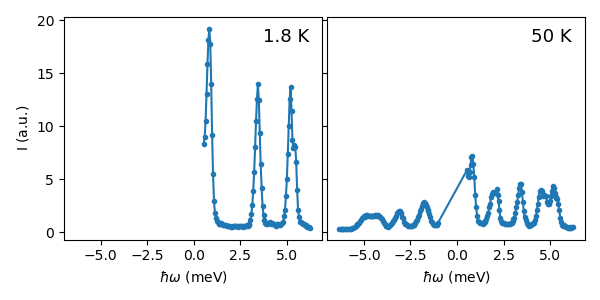

In [4]:
## Black out the elastic line, because it includes extra contributions from incoherent scattering, background, etc.
from copy import deepcopy

fitdata = deepcopy(alldata)

# fitdata[0][:,:100] *= np.nan
for i in range(len(fitdata)):
    fitdata[i].cx = np.hstack((fitdata[i].cx[20:120], fitdata[i].cx[150:265]))
    fitdata[i].ci = np.hstack((fitdata[i].ci[20:120], fitdata[i].ci[150:265]))
    fitdata[i].ce = np.hstack((fitdata[i].ce[20:120], fitdata[i].ce[150:265]))
    
fitdata[0].cx = fitdata[0].cx[100:]
fitdata[0].ci = fitdata[0].ci[100:]
fitdata[0].ce = fitdata[0].ce[100:]
    
f, ax = plt.subplots(1,2, figsize=(6,3), sharex=True, sharey=True)
for i,data in enumerate(fitdata):
    ax[i].errorbar(data.cx, data.ci, data.ce, marker='.')
    ax[i].text(0.95,0.95, str(datatemps[i])+' K', transform=ax[i].transAxes,
              verticalalignment='top', horizontalalignment='right', fontsize=13)
    ax[i].set_xlabel('$\\hbar \\omega$ (meV)')
ax[0].set_ylabel('$\\rm I$ (a.u.)')
    
plt.tight_layout()
f.subplots_adjust(wspace=0.02)

## Define global Chi2

In [5]:
# Build Hamiltonian, ignoring the negative stevens operators (because they shouldn't be allowed by symmetry).
ion = 'Er3+'
ionJ = cef.Jion[ion][2]

Er_O = []
for n in range(2,8,2):
    for m in range(0,n+1,3):
        if   n == 6: i = 8 + m
        elif n == 4: i = 3 + m
        elif n == 2: i = m
        Er_O.append(  cef.StevensOp(ionJ,n,m)  )

Coefficients = np.array([-4.02401422e-02, -3.77639706e-04,  1.42541502e-02,  3.17197840e-06,
        2.22389952e-06,  3.80096353e-05])
Er = cef.CFLevels(Er_O, Coefficients)
Er.diagonalize()
        
######################

def bkg(iii, x):
    if iii == 0:
        return gaus(x, 2, 3.5, 2.5) + 0.2  + gaus(x, 7, 0.1, 0.25)
    else:
        return gaus(x, 6.5, 1.5, 5) + 0.1  + gaus(x, 7, 0.1, 0.25)



def err_global_final(CFLevelsObject, coeff, gammas, xoff, pref, thermexp, bkgscale):
    """Global error to all functions passed to it, used for fitting"""
    # define new Hamiltonian
    newH = np.sum([a*b for a,b in zip(CFLevelsObject.O, coeff)], axis=0)
    CFLevelsObject.diagonalize(newH)

    erro = 0

    # Compute error in neutron spectrum
    for i,data in enumerate(fitdata):
        errspec = (pref* CFLevelsObject.normalizedNeutronSpectrum(Earray=data.cx*(1+datatemps[i]*thermexp)-xoff,
                                                                  Temp=datatemps[i],
                                    ResFunc= lambda de: straightline(de, *width_popt), gamma=gammas[i]) )+\
                bkg(i, data.cx)*bkgscale[i] - data.ci
        erro += np.nansum((errspec/data.ce)**2)


    sys.stdout.write("\r err = "+str(erro)+'    ')
    sys.stdout.flush() # important for printing progress
    return erro

# Compare the different best fit coefficients

In [6]:
CESFitCoefRes1b, CESFitCoefRes2b = np.load('CES_bestfitcoeff.npy',
                                          allow_pickle=True)

In [7]:
# Vary the coefficients so that reduced chi2 increases by 1
from scipy.optimize import minimize

B20_array = np.hstack((np.arange(1.0,0.7, -0.1) * CESFitCoefRes1b['coeff'][0],
                       (np.arange(0.65,1.25, 0.05) * CESFitCoefRes1b['coeff'][0])))
print(B20_array)

[-0.03558826 -0.03202944 -0.02847061 -0.02491179 -0.02313237 -0.02491179
 -0.0266912  -0.02847061 -0.03025003 -0.03202944 -0.03380885 -0.03558826
 -0.03736768 -0.03914709 -0.0409265  -0.04270592]


In [8]:
BestFitCoeffLine = []
for i,B20 in enumerate(B20_array):
    print('\n',i,' ', B20)
    
    def linefitfunction(parameters):
        newparameters = np.hstack(([B20], parameters[1:6]))
        return err_global_final(CFLevelsObject= Er, coeff=newparameters, 
                        gammas=parameters[6:8], xoff = parameters[8], 
                                bkgscale=[1,1], 
                          thermexp=parameters[9], pref=parameters[0])
    
    startingcoeffA = np.hstack((CESFitCoefRes1b['pref'], CESFitCoefRes1b['coeff'][1:6],
                            CESFitCoefRes1b['gammas'], CESFitCoefRes1b['xoff'], CESFitCoefRes1b['thermexp']))
    if i == 0:
        FitCoefResLineA= minimize(linefitfunction, x0 = startingcoeffA,  method = 'Nelder-Mead')
        BestFitCoeffLine.append(FitCoefResLineA)
        FitCoefResLine = FitCoefResLineA
    else:
        startingcoeffB = np.hstack((CESFitCoefRes1b['pref'], FitCoefResLine.x[1:6],
                            CESFitCoefRes1b['gammas'], CESFitCoefRes1b['xoff'], CESFitCoefRes1b['thermexp']))
        
        FitCoefResLineA = minimize(linefitfunction, x0 = startingcoeffA,  method = 'Nelder-Mead')
        FitCoefResLineB = minimize(linefitfunction, x0 = startingcoeffB,  method = 'Nelder-Mead')
        if FitCoefResLineA.fun < FitCoefResLineB.fun:
            FitCoefResLine = FitCoefResLineA
            BestFitCoeffLine.append(FitCoefResLineA)
        else:
            FitCoefResLine = FitCoefResLineB
            BestFitCoeffLine.append(FitCoefResLineB)


 0   -0.03558826477406324
 err = 5110.364548776646     
 1   -0.032029438296656915
 err = 5291.072214720059     
 2   -0.02847061181925059
 err = 5876.354979586042     
 3   -0.02491178534184427
 err = 5511.520406929619     
 4   -0.023132372103141105
 err = 5395.145603066214     
 5   -0.02491178534184427
 err = 5452.794284956719     
 6   -0.026691198580547432
 err = 5542.510953232969     
 7   -0.028470611819250598
 err = 5742.501309049358     
 8   -0.03025002505795376
 err = 6022.157517293554     
 9   -0.03202943829665692
 err = 6379.795508649257     
 10   -0.033808851535360084
 err = 5171.146735283917     
 11   -0.03558826477406325
 err = 5110.401619479311     
 12   -0.03736767801276641
 err = 5153.979370948695     
 13   -0.03914709125146958
 err = 5283.955074657938     
 14   -0.04092650449017274
 err = 5501.2203493770885    
 15   -0.04270591772887591
 err = 5805.739332520003     

In [9]:
numfreeparams = len(np.hstack(([alldata[i].ci for i in range(len(alldata))])))

bestfitline = [np.hstack((BestFitCoeffLine[i].x[0], B20_array[i], 
                          BestFitCoeffLine[i].x[1:], BestFitCoeffLine[i].fun/numfreeparams)) 
               for i in range(len(BestFitCoeffLine))]
bestfitline = np.array(bestfitline).T

<IPython.core.display.Javascript object>


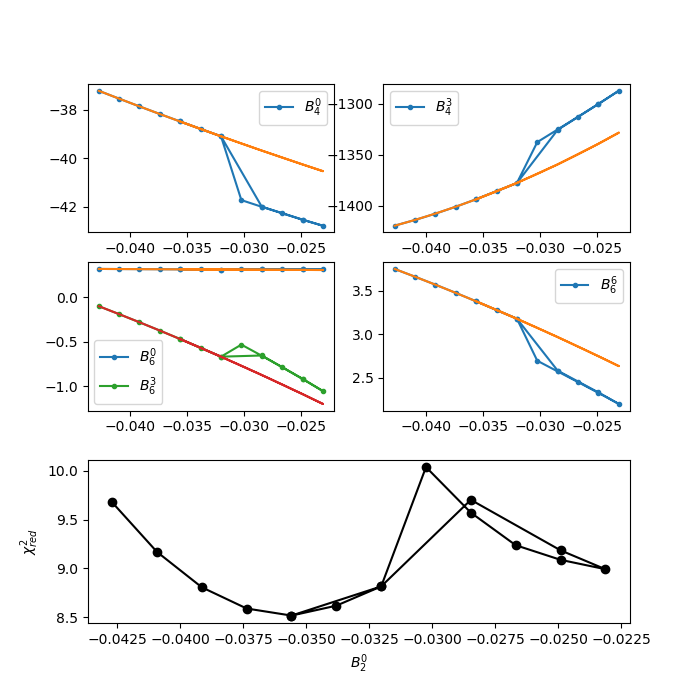

Text(0.5, 0, '$B_2^0$')

In [10]:
def curvedline(x,a,b, c):
    return a*x + b + c*x**2

ll = 9
B40popt, B40pcov = curve_fit(curvedline, bestfitline[1][ll:], bestfitline[0+2][ll:])
B43popt, B43pcov = curve_fit(curvedline, bestfitline[1][ll:], bestfitline[1+2][ll:])
B60popt, B60pcov = curve_fit(curvedline, bestfitline[1][ll:], bestfitline[2+2][ll:])
B63popt, B63pcov = curve_fit(curvedline, bestfitline[1][ll:], bestfitline[3+2][ll:])
B66popt, B66pcov = curve_fit(curvedline, bestfitline[1][ll:], bestfitline[4+2][ll:])


def bestfitCoeff(B20):
    return [B20, straightline(B20, *B40popt), straightline(B20, *B43popt), 
            straightline(B20, *B60popt), straightline(B20, *B63popt), curvedline(B20, *B66popt)]


##################### Plot 

fig = plt.figure(figsize=(7,7))
outer = gridspec.GridSpec(2,1, figure=fig, height_ratios=[2,1])
gs0 = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=outer[0])

ax1 = [fig.add_subplot(gs0[i,j]) for i in range(2) for j in range(2)]
ax2 = fig.add_subplot(outer[1])

bfstyle = {'marker':'.'}
scale = 1e5
ax1[0].plot(bestfitline[1], bestfitline[0+2]*scale, **bfstyle, label='$B_4^0$')
ax1[0].plot(bestfitline[1], curvedline(bestfitline[1], *B40popt)*scale)

ax1[1].plot(bestfitline[1], bestfitline[1+2]*scale, **bfstyle, label='$B_4^3$')
ax1[1].plot(bestfitline[1], curvedline(bestfitline[1], *B43popt)*scale)

ax1[2].plot(bestfitline[1], bestfitline[2+2]*scale, **bfstyle, label='$B_6^0$')
ax1[2].plot(bestfitline[1], curvedline(bestfitline[1], *B60popt)*scale)

ax1[2].plot(bestfitline[1], bestfitline[3+2]*scale, **bfstyle, label='$B_6^3$')
ax1[2].plot(bestfitline[1], curvedline(bestfitline[1], *B63popt)*scale)

ax1[3].plot(bestfitline[1], bestfitline[4+2]*scale, **bfstyle, label='$B_6^6$')
ax1[3].plot(bestfitline[1], curvedline(bestfitline[1], *B66popt)*scale)
    
for i in range(4):
    ax1[i].legend()
    
chisqstyle = {'marker':'o'}

#ax2.plot(bestfitline[1], bestfitline[-1]/(len(alldata[0].cx)+len(alldata[1].cx)), color='k',  **chisqstyle)
ax2.plot(bestfitline[1], bestfitline[-1], color='k',  **chisqstyle)
ax2.set_ylabel('$\\chi^2_{red}$')
#ax2.set_ylim(0,)
ax2.set_xlabel('$B_2^0$')

In [11]:
np.save('CES_loopthrough_bestfitline', bestfitline)